In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
## Raw preprocessing
# results = pd.read_csv("results/eval_mmlu-13b_chat-verb1s.csv")
# results = results.rename(columns={'fuzzy_gpt-3.5-turbo-1106_acc': 'acc',
#  'fuzzy_gpt-3.5-turbo-1106_unc_acc': 'unc_acc',
#  'fuzzy_gpt-3.5-turbo-1106_unc_ece': 'ece'})
# results.loc[:, "method"] = "verb1s"
# results.to_csv("results/eval_mmlu-13b_chat-verb1s.csv", index=False)

In [2]:
df = pd.read_csv("results/eval_mmlu-7b.csv")
# ct_results["method"] = "ct"

print(df[df.split == "test"]['ece'].mean())

0.1382168122753928


In [6]:
counting_df = pd.read_csv("results/metrics.csv")
counting_df["method"] = "sampling\n(counting)"
counting_df["ece"] = counting_df["fuzzy_gpt-3\\\\.5-turbo-1106_ece_counting"]
counting_df["acc"] = counting_df["fuzzy_gpt-3\\\\.5-turbo-1106_acc"]

likelihood_df = pd.read_csv("results/metrics.csv")
likelihood_df["method"] = "sampling\n(likelihood)"
likelihood_df["ece"] = likelihood_df["fuzzy_gpt-3\\\\.5-turbo-1106_ece_likelihood"]
likelihood_df["acc"] = counting_df["fuzzy_gpt-3\\\\.5-turbo-1106_acc"]

sampling_results = pd.concat([counting_df, likelihood_df])

In [7]:
ct_results = pd.read_csv("results/eval_mmlu-13b_chat-ct.csv")
ct_results["method"] = "CT"
ct_results["ece"] = ct_results["unc_ece"]

raw_results = pd.read_csv("results/eval_mmlu-13b_chat-base.csv")
raw_results["method"] = "unc. query\n(no CT)"
raw_results["ece"] = raw_results["unc_ece"]

verb_results = []
for version in ["1s1g", "1s2g", "2s1CoT", "2s1g", "2s2g"]:# "1s4g", "2s4g"]:
    _df = pd.read_csv(f"results/eval_mmlu-13b_chat-verb{version}.csv")
    _df = _df.groupby(["split", "dataset"]).first().reset_index()
    _df["method"] = f"verb{version}"

    if version == "2s1g":
        _df["unc_ece"] = _df["fuzzy_gpt-3.5-turbo-1106_unc_ece"]
        _df["acc"] = _df["fuzzy_gpt-3.5-turbo-1106_acc"]

    if "unc_ece" in _df.columns:
        if "ece" not in _df.columns:
            _df["ece"] = _df["unc_ece"]
        else:
            _df["ece"] = _df["ece"].fillna(_df["unc_ece"])
    if "ece" in _df.columns:
        if "unc_ece" not in _df.columns:
            _df["unc_ece"] = _df["ece"]
        else:
            _df["unc_ece"] = _df["unc_ece"].fillna(_df["ece"])

    verb_results.append(_df)

verb_results = pd.concat(verb_results, ignore_index=True)

# common_datasets = list(set(ct_results.dataset.unique()).intersection(verb1s_results.dataset.unique()))

# ct_results = ct_results[ct_results.dataset.isin(common_datasets)]

## Multiple evals?
# verb1s_results = verb1s_results[verb1s_results.dataset.isin(common_datasets)]

results = pd.concat([
    ct_results, 
    raw_results, 
    sampling_results,
    verb_results
], ignore_index=True)

In [8]:
_df = results[results.split == "test"]

# print number of rows per method
print(_df.groupby("method").count()["dataset"])


method
CT                        55
sampling\n(counting)      57
sampling\n(likelihood)    57
unc. query\n(no CT)       56
verb1s1g                  55
verb1s2g                  57
verb2s1CoT                57
verb2s1g                  57
verb2s2g                  56
Name: dataset, dtype: int64


In [129]:
# calculate the mean and std of the ECE
print(results[results.split == "test"].groupby("method").mean()["ece"])

method
CT                        0.118469
sampling\n(counting)      0.280669
sampling\n(likelihood)    0.283270
unc. query\n(no CT)       0.228976
verb1s1g                  0.289109
verb1s2g                  0.354820
verb2s1CoT                0.286185
verb2s1g                  0.299387
verb2s2g                  0.305198
Name: ece, dtype: float64


/tmp/ipykernel_1249260/4185496623.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(results[results.split == "test"].groupby("method").mean()["ece"])


In [83]:
mendl[1]

'#B8C0F6'

/tmp/ipykernel_1249260/2074125355.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


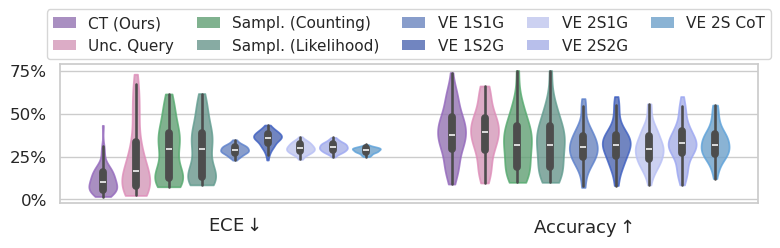

In [187]:
import palettable

new_df = []

for ece, acc, method, split in results[['ece', 'acc', 'method', 'split']].values:
    new_df.append({
        "value": ece,
        "metric": "ECE$\downarrow$",
        "method": method,
        "split": split
    })
    new_df.append({
        "value": acc,
        "metric": "Accuracy$\\uparrow$",
        "method": method,
        "split": split
    })

df = pd.DataFrame(new_df)

df = df[df.split == "test"]

name_map = {
    "CT": "CT (Ours)",
    "unc. query\n(no CT)": "Unc. Query",
    "sampling\n(counting)": "Sampl. (Counting)",
    "sampling\n(likelihood)": "Sampl. (Likelihood)",
    "verb1s1g": "VE 1S1G",
    "verb1s2g": "VE 1S2G",
    "verb2s1g": "VE 2S1G",
    "verb2s2g": "VE 2S2G",
    "verb2s1CoT": "VE 2S CoT",
}
df["method"] = df["method"].map(name_map)

mendl = palettable.wesanderson.Mendl_4.hex_colors
moonrise45 = palettable.wesanderson.Moonrise4_5.hex_colors

color_map = {
    "CT": "#9468bd",
    "No CT": mendl[0],
    "Counting": "#55aa6f",
    "Likelihood": "#629d90",
    "Verb1s": mendl[3],
    "Verb1g": "#3d5fc2",
    "Verb2s1g": mendl[1],
    "Verb2s2g": "#9ca7f2",
    "Verb2s1CoT": "#5da2da",
}


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(9, 1.8))

sns.violinplot(
    df,
    x="metric",
    y="value",
    hue="method",
    hue_order=name_map.values(),
    palette=color_map.values(),
    cut=0,
    density_norm="width",
    width=0.85,
    gap=0.15,
    alpha=0.8,
    ax=ax,
)   

from matplotlib.collections import PolyCollection
violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
for i, violin in enumerate(violins):
    print(violin)
    violin.set_edgecolor(list(color_map.values())[i % len(color_map)])

#rotate xticks
# plt.xticks(rotation=15)
ax.set_xlabel("")
ax.set_ylabel("")

#turn y tick labels into percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

#increase yticks font size and xticks font size
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=13)

# ax.tick_params(axis='y', pad=0)

#make legend above the plot with two rows
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.45), 
    ncol=5, columnspacing=1.5, handlelength=1.5,# handletextpad=0.5, handlelength=1.5, fontsize=12
)

#remove edge from patches in the legend
for l in ax.legend_.get_patches():
    l.set_edgecolor('none')

#save as pdf

plt.savefig("open_ended_violins.pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_1249260/3346011096.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


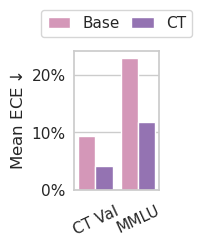

In [189]:
sns.set_theme(style="whitegrid")

df = pd.DataFrame([
    {"method": "Base", "split": "CT Val", "ECE": 0.0932806276679039},
    {"method": "CT", "split": "CT Val", "ECE": 0.0421182975769042},
    {"method": "Base", "split": "MMLU", "ECE": 0.228976},
    {"method": "CT", "split": "MMLU", "ECE": 0.118469},
])

color_map = {
    "Base": mendl[0],
    "CT": "#9468bd",
}

fig, ax = plt.subplots(figsize=(1.1, 1.8))

sns.barplot(
    ax=ax,
    data=df,
    x="split",
    y="ECE",
    hue="method",
    palette=color_map.values(),
)

ax.set_xlabel("")
ax.set_ylabel("Mean ECE$\downarrow$")

#turn y tick labels into percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

#rotate xticks
plt.xticks(rotation=25)

#reduce space between yticklabels and y axis
ax.tick_params(axis='y', pad=0)

ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2,
    #no padding
    borderaxespad=0.0,columnspacing=0.7, handlelength=1.5
)

plt.savefig("val_loss_comparison.pdf", bbox_inches="tight")

plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'CT'),
  Text(1, 0, 'unc. query\n(no CT)'),
  Text(2, 0, 'sampling\n(counting)'),
  Text(3, 0, 'sampling\n(likelihood)'),
  Text(4, 0, 'verb1s1g'),
  Text(5, 0, 'verb1s2g'),
  Text(6, 0, 'verb1s4g'),
  Text(7, 0, 'verb2s1CoT'),
  Text(8, 0, 'verb2s1g'),
  Text(9, 0, 'verb2s2g'),
  Text(10, 0, 'verb2s4g')])

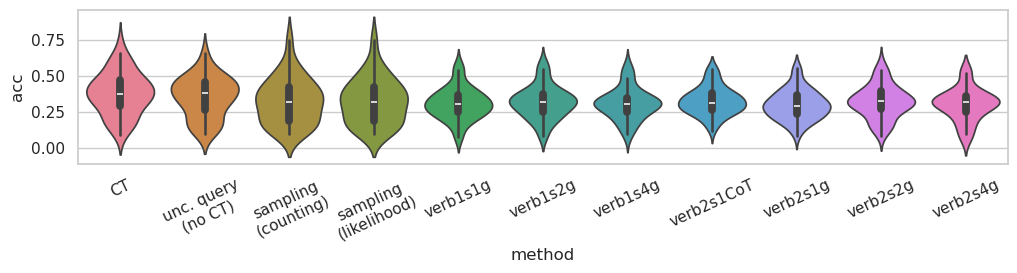

In [11]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 2))

sns.violinplot(
    results[results.split == "test"],
    x="method",
    y="acc",
    hue="method",
    ax=ax,
)

#rotate xticks
plt.xticks(rotation=25)

In [6]:
dname_map = {d: idx + 1 for idx, d in enumerate(results.dataset.unique())}

plt_results = results[results.split == "test"]
plt_results["task_idx"] = results.dataset.apply(lambda d: dname_map[d])
plt_results["ece_100"] = results["ece"] * 100.
plt_results["acc_100"] = results["acc"] * 100.
plt_results["unc_acc_100"] = results["unc_acc"] * 100.
plt_results = plt_results.sort_values("task_idx")
plt_results

/tmp/ipykernel_6304/1789983019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_results["task_idx"] = results.dataset.apply(lambda d: dname_map[d])
/tmp/ipykernel_6304/1789983019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_results["ece_100"] = results["ece"] * 100.
/tmp/ipykernel_6304/1789983019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,acc,unc_acc,ece,N,split,seed,model_name,model_dir,peft_dir,query_peft_dir,...,mode,log_dir,dataset,ts,method,unc_ece,task_idx,ece_100,acc_100,unc_acc_100
1,0.370915,0.449346,0.206790,612,test,137,llama2_13b_chat,NaN,NaN,/data/users/sanyam_s/models/llm-calibration/Ll...,...,oe_fuzzy_gpt-3.5-turbo-1106,/data/users/sanyam_s/logs/deeplearn/llm-calibr...,mmlu:professional_psychology,2834.021050,ct,NaN,1,20.679009,37.091503,44.934642
158,0.259804,1.000000,0.303110,612,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic,mmlu:professional_psychology,6014.632859,verb1s,NaN,1,30.310961,25.980392,100.000000
270,0.269608,1.000000,NaN,612,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_1s2g_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic_1s2g,mmlu:professional_psychology,17947.171252,NaN,0.375817,1,NaN,26.960784,100.000000
383,0.250000,1.000000,NaN,612,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_1s4g_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic_1s4g,mmlu:professional_psychology,23602.182660,NaN,0.469608,1,NaN,25.000000,100.000000
347,0.263158,1.000000,NaN,114,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_1s4g_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic_1s4g,mmlu:econometrics,5452.792475,NaN,0.445614,2,NaN,26.315790,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.587879,1.000000,0.297239,165,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic,mmlu:high_school_european_history,2351.631359,verb1s,NaN,56,29.723907,58.787876,99.999994
355,0.587879,1.000000,NaN,165,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_1s4g_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic_1s4g,mmlu:high_school_european_history,7692.807899,NaN,0.466667,56,NaN,58.787876,99.999994
250,0.495098,1.000000,NaN,204,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_1s2g_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic_1s2g,mmlu:high_school_us_history,6899.831782,NaN,0.406863,57,NaN,49.509805,100.000000
140,0.534314,1.000000,0.283582,204,test,137,llama2_13b_chat,NaN,NaN,NaN,...,ve_oe_fuzzy_gpt-3.5-turbo-1106,verbal_elic,mmlu:high_school_us_history,2269.375512,verb1s,NaN,57,28.358194,53.431374,100.000000


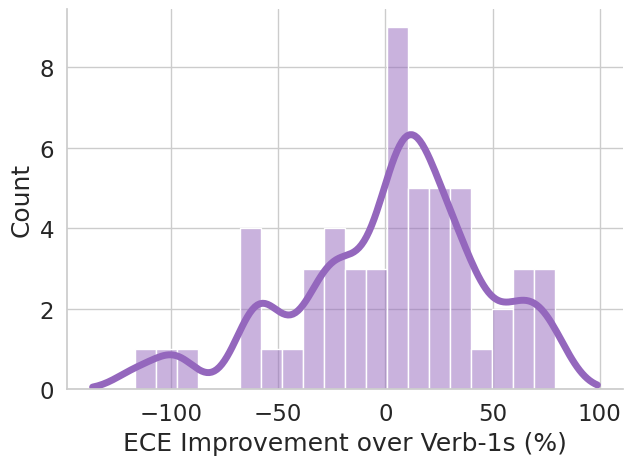

In [7]:
sns.set_theme(font_scale=1.5, style="whitegrid")

ref = plt_results[plt_results.method == "verb1s"]["ece_100"].values
new = plt_results[plt_results.method == "ct"]["ece_100"].values
# ref = plt_results[plt_results.method == "raw_13b_chat"]["ece_100"].values

g = sns.displot(pd.DataFrame({ "rel_imp": -((new - ref) / ref) * 100. }),
                # kind="kde", fill=True, bw_adjust=.5,
                kde=True, stat="count", kde_kws={"bw_adjust": .5, "cut": 2}, binwidth=10,
                height=5, aspect=4/3, legend=False,
                palette=sns.color_palette("tab20")[8:9])

g.ax.get_lines()[0].set(linewidth=5)

g.set(xlabel="ECE Improvement over Verb-1s (%)")

g.fig.tight_layout()
g.fig.show()
# g.fig.savefig("mmlu_rel_imp_qa_oe.pdf", bbox_inches="tight")

In [ ]:
sns.set_theme(font_scale=6., style="whitegrid")

fig, ax = plt.subplots(figsize=(100, 40))

ax = sns.barplot(ax=ax, data=plt_results,
                 x="task_idx", y="ece_100", hue="method",
                 width=0.68,
                 hue_order=["ct", "verb1s"],
                 palette=sns.color_palette("tab20")[8:10])

ax.set_ylabel(r'$\mathrm{ECE} (\%)$', fontsize=250, labelpad=100)
# ax.set_yticks(np.arange(0, 60 + 1e-3, 10))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=150)

ax.set_xlabel('MMLU Task ID', fontsize=250, labelpad=100)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=150)

handles, labels = ax.get_legend_handles_labels()
label_map = { "base": "Base", "ct": "CT", "verb1s": "Verb-1S" }
labels = [label_map[l] for l in labels]

ax.legend(handles=handles, labels=labels, loc='best',
          title='', title_fontsize=200,
          prop=dict(size=180))#, bbox_to_anchor=(.91, .7, .1, .1))

fig.tight_layout()
fig.show()
# fig.savefig("mmlu_oe_ece_comparison.pdf", bbox_inches="tight")

In [ ]:
sns.set_theme(font_scale=6., style="whitegrid")

fig, ax = plt.subplots(figsize=(100, 40))

ax = sns.barplot(ax=ax, data=plt_results,
                 x="task_idx", y="acc_100", hue="method",
                 width=0.68,
                 hue_order=["ct", "verb1s"],
                 palette=sns.color_palette("tab20")[8:10])

ax.set_ylabel('Query Acc. (%)', fontsize=250, labelpad=100)
ax.set_yticks(np.arange(0, 100 + 1e-3, 20))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=150)

ax.set_xlabel('MMLU Task ID', fontsize=250, labelpad=100)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=150)

handles, labels = ax.get_legend_handles_labels()
label_map = { "base": "Base", "ct": "CT", "verb1s": "Verb-1S" }
labels = [label_map[l] for l in labels]

ax.legend(handles=handles, labels=labels, loc='best',
          title='', title_fontsize=200,
          prop=dict(size=180))#, bbox_to_anchor=(.91, .7, .1, .1))

fig.tight_layout()
fig.show()
# fig.savefig("mmlu_oe_qacc_comparison.pdf", bbox_inches="tight")

In [5]:
import pickle

with open("../AirPassengersDataset.pkl", "rb") as f:
    d = pickle.load(f)

print(d)

{'gp': {'NLL/D': 5.904887193870207, 'median': array([449.48163, 441.1775 , 418.3423 , 375.36902, 361.37527, 350.5984 ,
       341.03793, 375.49155, 406.68256, 435.699  , 479.3543 , 500.99374,
       497.70898, 492.58774, 471.74847, 427.54398, 409.92154, 396.75452,
       383.61853, 415.71155, 447.57425, 477.70383, 524.7103 , 551.41046,
       552.1811 , 549.1222 , 529.2794 , 483.0952 , 460.82828],
      dtype=float32), 'samples': array([[446.39545, 446.12073, 449.6508 , ..., 546.3689 , 539.024  ,
        506.49838],
       [420.7023 , 427.093  , 449.9105 , ..., 540.644  , 463.45312,
        419.6527 ],
       [450.52557, 412.12347, 394.75232, ..., 527.0474 , 493.85376,
        449.7777 ],
       ...,
       [476.22458, 442.7963 , 445.2302 , ..., 532.3994 , 508.00198,
        469.23895],
       [458.66995, 457.60117, 420.82983, ..., 551.2691 , 458.95172,
        488.78653],
       [442.6717 , 469.8258 , 427.54935, ..., 515.4847 , 522.3036 ,
        491.9954 ]], dtype=float32), 'info': {